# Filter Bank

## Import libraries

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from numpy import convolve as conv
import pandas as pd
from mat4py import loadmat

## Functions

### Alternate coefficients signals

In [2]:
def alternate_coefficients_signals(h):
    h0_ = np.array(h)
    h0_[1:len(h0_):2] = -h0_[1:len(h0_):2]
    return list(h0_)

### Polynomial sum

In [3]:
def poly_sum(x, y):
    x1 = np.zeros(max(len(x), len(y)))
    y1 = np.copy(x1)
    x1[:len(x)] = x
    y1[:len(x)] = y
    z = x1 + y1
    return z

### Evaluate decomposition synthesis filters

In [4]:
def evaluate_decomposition_synthesis_filters(h0, h1, g0, g1, tol=1e-8):
    h0_ = alternate_coefficients_signals(h0)
    h1_ = alternate_coefficients_signals(h1)
    alias_term = poly_sum(conv(h0_, g0), conv(h1_, g1))
    perfect_reconstruction = (np.sum(np.where(alias_term < tol, 0, alias_term)) == 0)
    lti_term = poly_sum(conv(h0, g0),conv(h1, g1));
    k = list(np.where(np.abs(lti_term) >= tol))[0]
    perfect_reconstruction = ((len(k) == len(lti_term)) & perfect_reconstruction)
    A = lti_term[k]/2.0;
    d = k-1;
    return perfect_reconstruction, A, d

### Downsample and upsample

In [9]:
def downsample(x, factor):
    x = x[:len(x):factor]
    return x
def upsample(x, factor):
    y = np.zeros(len(x)*factor)
    y[:len(y):factor] = x
    return y

### QMF 1 level decomposition and synthesis

In [6]:
def qmf_decomposition_1level(x, h0, h1):
    w0 = np.convolve(h0, x)
    w1 = np.convolve(h1, x)
    x0 = downsample(w0, 2)
    x1 = downsample(w1, 2)
    xd = np.append(x0, x1)
    return xd

def qmf_synthesis_1level(xd, g0, g1):
    u0 = upsample(xd[:int(len(xd)/2)], 2)
    u1 = upsample(xd[int(len(xd)/2):], 2)
    y0 = np.convolve(g0, u0)
    y1 = np.convolve(g1, u1)
    yd = poly_sum(y0, y1)
    return yd

### Filter iterator

In [12]:
def filter_iterator(h0, h1, levels):
    h0 = np.array(h0)
    h1 = np.array(h1)
    h = [0] * (levels+1)
    h[levels] = h1
    aux = np.copy(h0)
    for n in range(levels, 1, -1):
        h_ = upsample(h[n], 2)
        h_ = h_[:len(h_) - 1]
        h[n-1] = conv(h_, h0)
        aux = upsample(aux, 2)
        aux = aux[:len(aux) - 1]
        aux = conv(aux, h0)
    h[0] = aux
    return h

## Evaluate decomposition synthesis filters

In [10]:
data = loadmat('sinais_ecg/ecg01.mat')
data = np.array(data['x'])
data_n = data[:500,0]

In [11]:
data_qmf = qmf_decomposition_1level(data_n, [1,1], [1,-1])
data_rec = qmf_synthesis_1level(data_qmf, [1,1], [1,-1])

<IPython.core.display.Javascript object>


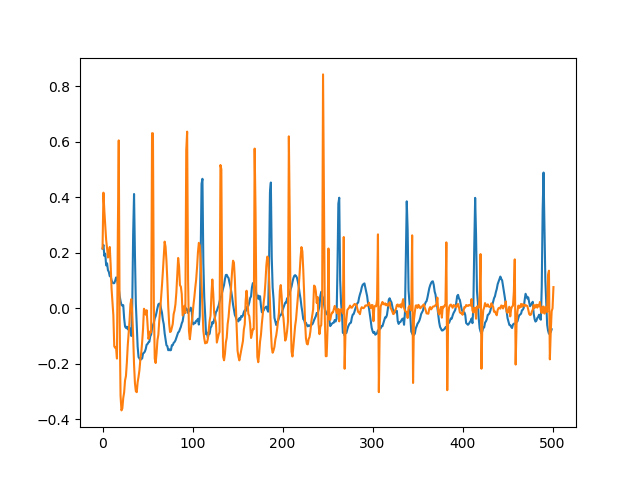

In [12]:
plt.figure()
plt.plot(data_n)
plt.plot(data_qmf)
plt.show()

## Filter iterator

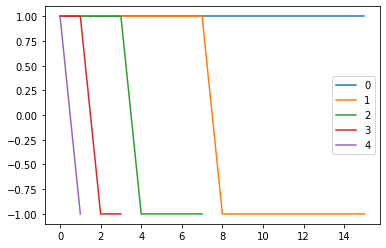

In [13]:
%matplotlib inline
h = filter_iterator([1,1], [1,-1], 4)
plt.figure()
for n in range(len(h)):
    plt.plot(h[n], label=str(n))
    plt.legend()
plt.show()

## General QMF Filter Decomposition

In [14]:
def qmf_decomposition(x, h0, h1, levels):
    h = filter_iterator(h0, h1, levels)
    xdc = [0] * (levels + 1)
    xd = []
    downsample_factor = 1
    for n in range(levels, -1, -1):
        downsample_factor *= 2
        xdc[n] = downsample(conv(h[n], x), downsample_factor)
        xd = np.append(xdc[n], xd)
    xdc[0] = downsample(conv(h[0], x), downsample_factor)
    return xdc, xd

<IPython.core.display.Javascript object>


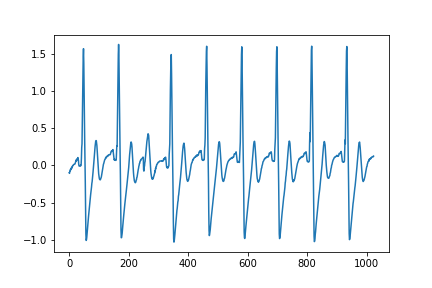

In [26]:
data = loadmat('sinais_ecg/ecg06.mat')
data = np.array(data['x'])
data_n = data[:1024,0]
plt.figure()
plt.plot(data_n)
plt.show()

In [16]:
h0 =  [0.0033357253,-0.0125807520,-0.0062414902,0.0775714938,-0.0322448696,
       -0.2422948871,0.1384281459,0.7243085284,0.6038292698,0.1601023980]
h1 = [-0.1601023980,0.6038292698,-0.7243085284,0.1384281459,0.2422948871,
    -0.0322448696,-0.0775714938,-0.0062414902,0.0125807520,0.0033357253]

In [21]:
xdc, xd = qmf_decomposition(data_n, h0, h1, 4)

<IPython.core.display.Javascript object>


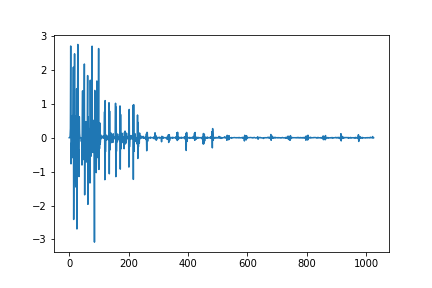

In [25]:
%matplotlib notebook
plt.figure()
plt.plot(xd)
plt.show()

## General Filter Reconstruction

In [ ]:
def qmf_decomposition(xdc, h0, h1, g0, g1, d):
    levels = len(xdc) - 1
    compensatory_delay = d
    for n range(2, len(xdc) + 1):
        xdc[n] = np.append(np.zeros(compensatory_delay, 1), xdc[n])
        compensatory_delay = compensatory_delay + 2^(n-2)*d
    return x, xd, delay

In [ ]:
a = np.zeros([10, 1])

In [ ]:
a